# 01 Data Labeling

## 1. 추세 판단 분류기 만들기

### 분류기 개발 방안

* 지도학습 기반 분류기를 개발합니다.
* 상승: 1 / 하락: 0 으로 Labeling을 수행합니다.
* 분류기는 RandomForest를 기반으로 Bagging 분류기를 만들도록 하겠습니다.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

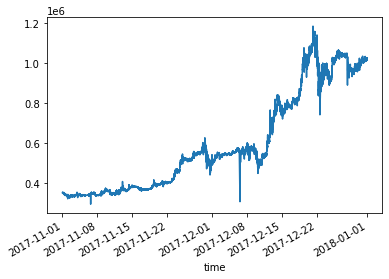

In [3]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31', 'close'].plot()

In [4]:
modify_data

,open,high,low,close,volume
time,,,,,
2017-09-25 03:00:00,324500,325500,322000,324000,52.477251
2017-09-25 03:01:00,324000,324000,322500,324000,39.061889
2017-09-25 03:02:00,322500,324500,322500,324500,12.794000
2017-09-25 03:05:00,324000,324000,323000,324000,33.365246
2017-09-25 03:06:00,324000,325000,322500,324000,46.224544
...,...,...,...,...,...
2019-11-03 10:29:00,212650,212800,212600,212800,30.996276
2019-11-03 10:30:00,212800,212800,212600,212600,3.224132
2019-11-03 10:31:00,212600,212600,212400,212400,135.351681


## 2. Data Labeling
추세(Trend)를 Labeling하는 4가지 방법
* Price Change Direction
* Using Moving Average
* Local Min-Max
* Trend Scanning

### Price Change Direction
* 가장 단순한 방식
* 현재 종가와 N일 전 종가와의 차이를 비교
* 몇일 전 가격과 비교할 것인지의 결정에 따라 변동이 커질 수 있어서, 세심한 주의 요함
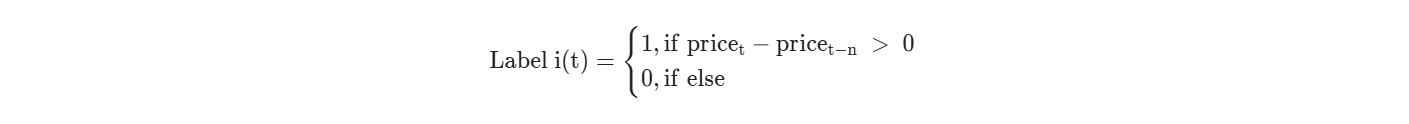

In [5]:
window = 10
momentum_signal=np.sign(np.sign(   modify_data['close'] - modify_data['close'].shift(window)) + 1)

In [11]:
display(type(momentum_signal))
momentum_signal

pandas.core.series.Series

time
2017-09-25 03:00:00    NaN
2017-09-25 03:01:00    NaN
2017-09-25 03:02:00    NaN
2017-09-25 03:05:00    NaN
2017-09-25 03:06:00    NaN
                      ... 
2019-11-03 10:29:00    1.0
2019-11-03 10:30:00    0.0
2019-11-03 10:31:00    0.0
2019-11-03 10:32:00    0.0
2019-11-03 10:33:00    0.0
Name: close, Length: 1000000, dtype: float64

In [7]:
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

In [12]:
display(s_momentum_signal)
type(s_momentum_signal)

time
2017-09-25 03:00:00    NaN
2017-09-25 03:01:00    NaN
2017-09-25 03:02:00    NaN
2017-09-25 03:05:00    NaN
2017-09-25 03:06:00    NaN
                      ... 
2019-11-03 10:29:00    1.0
2019-11-03 10:30:00    0.0
2019-11-03 10:31:00    0.0
2019-11-03 10:32:00    0.0
2019-11-03 10:33:00    0.0
Name: close, Length: 1000000, dtype: float64

pandas.core.series.Series

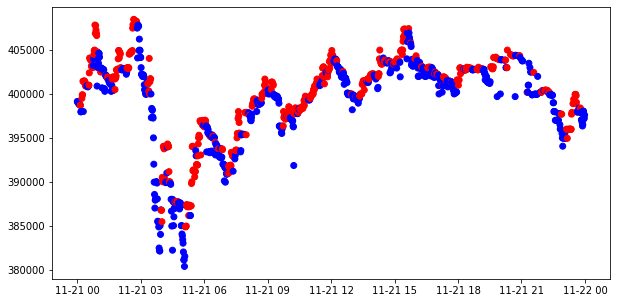

In [28]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')   # np.where  : 조건에 만족하는 위치 인덱스 찾기

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data , c=c_sig['color']) #

### Using Moving Average
* 기술적 지표를 이용하여 라벨링 하는 여러 방식이 있음.
* 여기서는 이동평균선 이용한 방식 사용
* 현재의 주가가 특정 이동평균선 위에 있는지, 아래에 있는지 여부로 Labeling을 하는 방식
* 가격 차이만으로 Labeling할 경우와 마찬가지로, 이동평균을 며칠로 할 것이냐를 결정하여야 하고, 이동평균으로 인해 Lag(지연)가 발생할 수 있음.

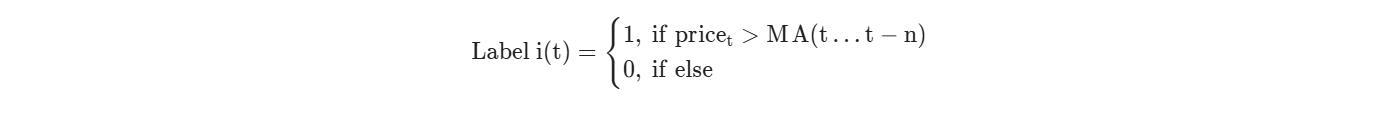

In [30]:
# momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

display(s_momentum_signal)

time
2017-09-25 03:00:00    NaN
2017-09-25 03:01:00    NaN
2017-09-25 03:02:00    NaN
2017-09-25 03:05:00    NaN
2017-09-25 03:06:00    NaN
                      ... 
2019-11-03 10:29:00    0.0
2019-11-03 10:30:00    0.0
2019-11-03 10:31:00    0.0
2019-11-03 10:32:00    0.0
2019-11-03 10:33:00    0.0
Name: close, Length: 1000000, dtype: float64

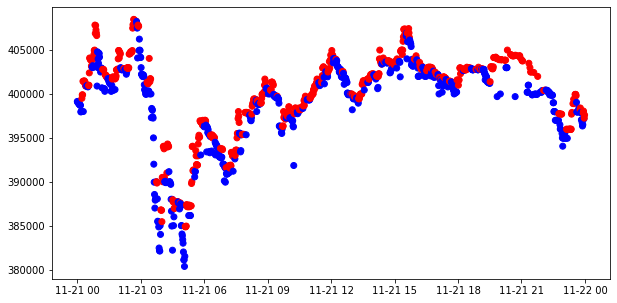

In [32]:
sub_data = modify_data.loc['2017-11-21', 'close']

c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### Local Min-Max
국지적인 최소 / 최대값을 계속 갱신하여, 최소-최대 구간을 이어나가며 Labeling

여기서 소개하는 알고리즘만이 정답은 아님, 국지적 최소 최대를 갱신할 수 있는 여러 방법이 있음

* 이 알고리즘은 계속해서 최소, 최대값을 갱신하다가, 서로 상대방값으로 초기화해 줌.

 ex> 현재 하락구간이어서 최소값이 계속 갱신되고 있다고 가정
 
이전 최대값은 3,000원이고, 직전까지 최소값은 2,800원인데, 현재가격이 2,750원으로 더 낮아졌다면, 최소값이 갱신 됨

다음 가격이 2,800원으로 상승을 시작했다면, 현재 하락구간은 종료되었다는 가정하에 최소값 갱신을 멈추고
이전 최대값을 현재 최소값인 2,750원으로 변경, 앞으로 상승구간에서 최대값 갱신이 가능하도록 조정


여기서, 현재가격이 한번 상승했다고 바로 하락구간 종료를 가정하면, 빈번한 Labeling의 변화가 있을 수 있으므로, 좀 더 변동이 적은 작업을 위해 Wait 계수를 설정할 수 있습니다.

상승구간에서의 과정도 하락구간과 동일합니다.

* 단점 

    * 순차적인 가격 확인이 요구되는 만큼 데이터가 증가하면, 선형적으로 연산시간도 늘어 남.

    * Wait 계수를 작게하면 변동성이 커질 수 있으므로, 신중한 계수선택이 요구
    

𝐼𝑛𝑖𝑡𝑖𝑎𝑙𝑖𝑧𝑒 𝑣𝑎𝑟𝑖𝑎𝑏𝑙𝑒𝑠𝑓𝑜𝑟 𝑖 𝑖𝑛 𝑑𝑎𝑡𝑎𝑠𝑒𝑡:

    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒<𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
    
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒
        
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
        
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒>𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
    
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒
        
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
        
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
    
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
        
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
    
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
        
[Pseudo-code]

In [35]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [36]:
mins, maxes = get_local_min_max(sub_data, wait=3)

In [37]:
mins

,min_time,local_min
0,2017-11-21 00:01:00,399050
1,2017-11-21 00:03:00,399000
2,2017-11-21 00:04:00,398900
3,2017-11-21 00:05:00,398850
4,2017-11-21 00:06:00,398800
...,...,...
472,2017-11-21 23:48:00,397850
473,2017-11-21 23:50:00,397050
474,2017-11-21 23:52:00,396750
475,2017-11-21 23:53:00,396350


In [38]:
maxes

,max_time,local_max
0,2017-11-21 00:13:00,399500
1,2017-11-21 00:14:00,399900
2,2017-11-21 00:16:00,401450
3,2017-11-21 00:19:00,401350
4,2017-11-21 00:20:00,401500
...,...,...
268,2017-11-21 23:41:00,398050
269,2017-11-21 23:43:00,398400
270,2017-11-21 23:46:00,398200
271,2017-11-21 23:47:00,398400


(376546.5, 412585.0)

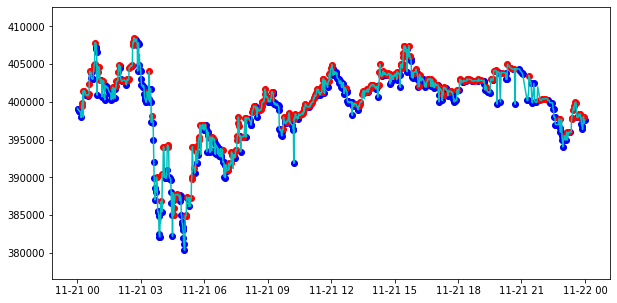

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')

ax.set_ylim([sub_data.min() * 0.99, sub_data.max() * 1.01])

(376546.5, 412585.0)

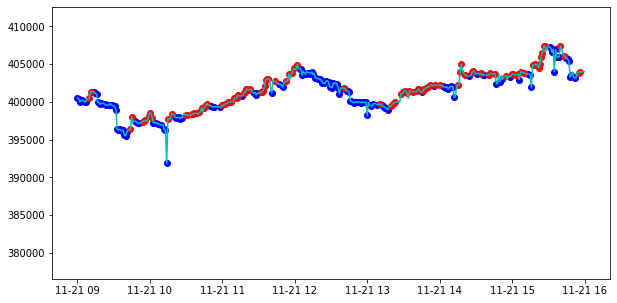

In [41]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

In [42]:
mins.shape[0], maxes.shape[0]

(477, 273)

### Trend Scanning
Marcos Lopez de Prado 의 저서 'Machine Learning for Asset Managers'에 소개된 Labeling 방식
 
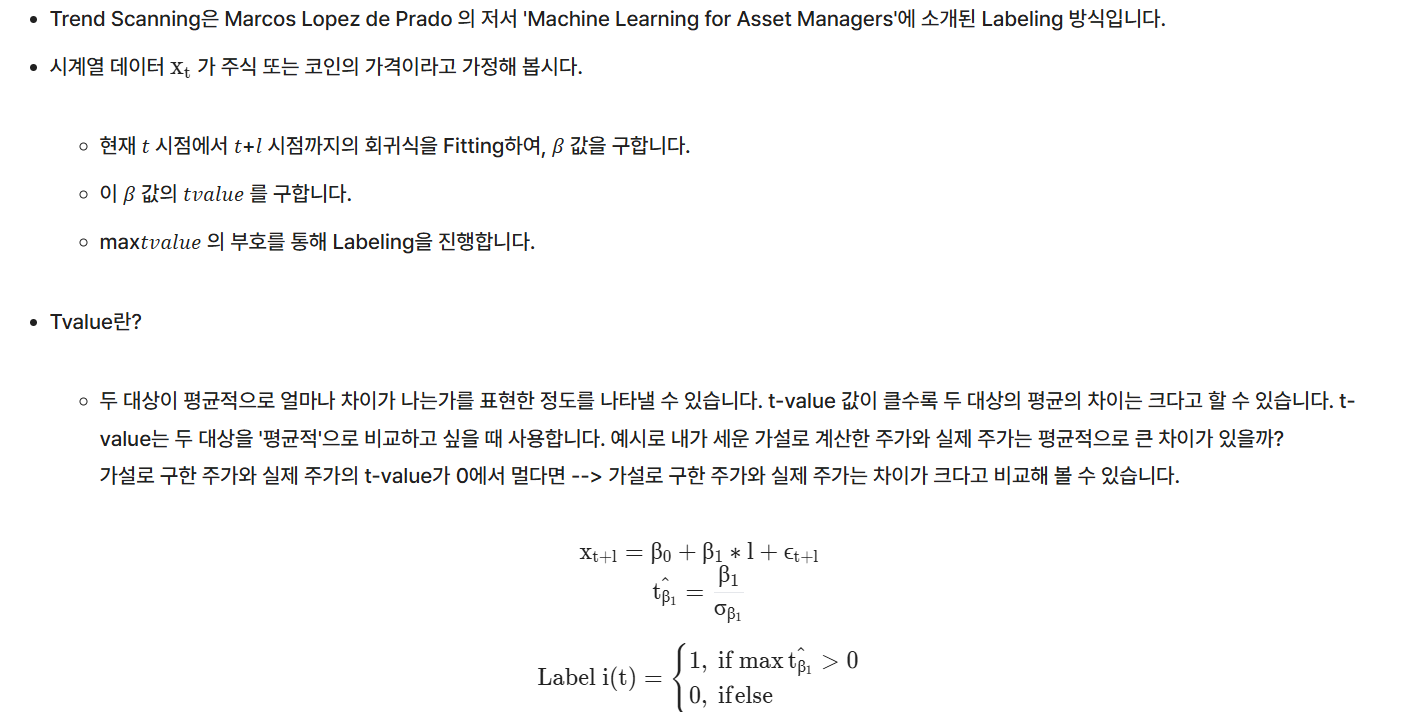

In [44]:
# np.ones()
# shape: 생성할 배열의 형태를 지정합니다. shape은 정수 또는 정수들의 튜플로 입력됩니다.
# dtype (선택 사항): 배열의 데이터 타입을 지정합니다. 기본값은 None이며, 주어지지 않을 경우 입력된 값에 따라 자동으로 결정됩니다.
# order (선택 사항): 배열의 메모리 배치 순서를 지정합니다. 기본값은 'C'로, C 스타일의 로우 메이저(row-major) 순서로 배열이 배치됩니다.


# Ordinary Least Squares - OLS
 

def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))        # 주어진 형태(shape)의 배열을 생성하며, 모든 요소를 1로 초기화
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [46]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [47]:
# 이 코드 블럭은 실행에 20~30분정도 걸립니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:09<00:00, 42.27it/s]


In [52]:
label

,t1,t_val,bin
time,,,
2017-11-01 00:05:00,2017-11-01 06:10:00,-6.373987,-1
2017-11-01 00:12:00,2017-11-01 06:16:00,-6.273936,-1
2017-11-01 00:18:00,2017-11-01 06:23:00,-5.897474,-1
2017-11-01 00:24:00,2017-11-01 06:29:00,-5.425023,-1
2017-11-01 00:31:00,2017-11-01 06:35:00,-5.08177,-1
...,...,...,...
2017-11-30 23:55:00,2017-12-01 00:54:00,-6.890995,-1
2017-11-30 23:56:00,2017-12-01 00:55:00,-7.337545,-1
2017-11-30 23:57:00,2017-12-01 00:56:00,-7.797664,-1


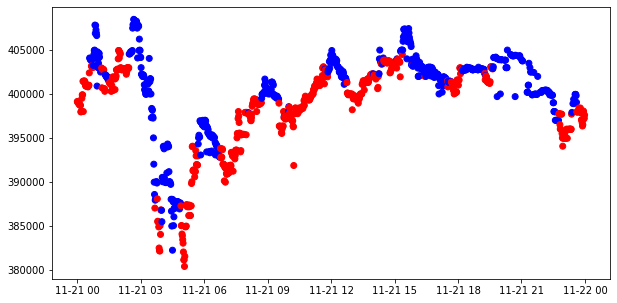

In [48]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

# 02. Feature Engineering
도메인 지식을 활용하여 정제되지 않은 원본 자료(raw data)를 탐색과 분석, 가공을 거쳐 특성추출 및 특성을 선택

Technical Index
- 기존 데이터셋(시가, 고가, 저가, 종가, 거래량)에서 기술적 지표(추세, 변동성, 거래량, 모멘텀)를 적용한 데이터셋 만들기
- 새로 만든 데이터셋에서 활용하고자 하는 시점에 대한 수익률, 변화율, 변동성을 적용


Feature Selection methods
- 특성추출(Feature Extraction)과 특성선택(Feature Selection) 중 특성선택을 하는 방법으로 접근하여 어떤 방법론이 있는지 확인해봅시다.

    * Feature Selection
    * Sequential Feature Selection
    * Shapley Additive explanations
    
    
------------
* 분류기의 설명력을 높이고, 성능을 개선하기 위해서 가장 중요한 것은 적절한 Feature를 선택하는 것
* Feature 선택 방식
    * Filter Method: Feature들간의 연관성을 찾는 방식(information gain, correlation coefficient 등)
    * Wrapper Method: 해결하고자 하는 문제에 대한 유용성을 측정하는 방식. 
            Validation set에서의 성능이 최대화되는 Feature Set을 선정 
            (Recursive Feature Elimination, Sequential Feature Selection 등)
    * Embedded Method: 훈련의 알고리즘에 Feature 선정과정이 포함되는 방식(Lasso, Ridge, Elastic Net 등)
    
    
* 이 중 Wrapper Method 몇 가지에 대한 사용방법을 알아보고, 이 외에 Prodo 의 저서 'Advances in Financial ML'에서 소개된 방식에 대해 알아보겠음.
* 주가 모멘텀 포착을 위해 사용할 수 있는 Feature들에는 무엇이 있는지 알아보고, 그 Feature 들 중 어떤 Feature를 선정해야 하는지 여러 방식으로 분석해 보도록 하겠습니다.
* 'SHAP'이라는 Feature 분석 패키지를 통해 Feature의 중요도를 확인해 보도록 하겠습니다.

## 1. 환경구성 및 데이터 불러오기

In [53]:
# !pip install ta==0.9.0
# !pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28907 sha256=109c82a3af7824e5baf2feacfb5ef70e86029210080d0899dd7500f24a2e76bf
  Stored in directory: /aiffel/.cache/pip/wheels/d1/3c/c4/176cfd752bd625c697799269715459e85c6dfd9500df26ad93
Successfully built ta
     |████████████████████████████████| 539 kB 4.1 MB/s            


In [1]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [2]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

In [3]:
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# df_sub_modify_data

In [4]:
# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [5]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [6]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [7]:
df_label_data.value_counts()

-1.0    306636
-0.0    302963
 1.0    299289
Name: t_value, dtype: int64

## 2. Technical Index
① 기술적 지표
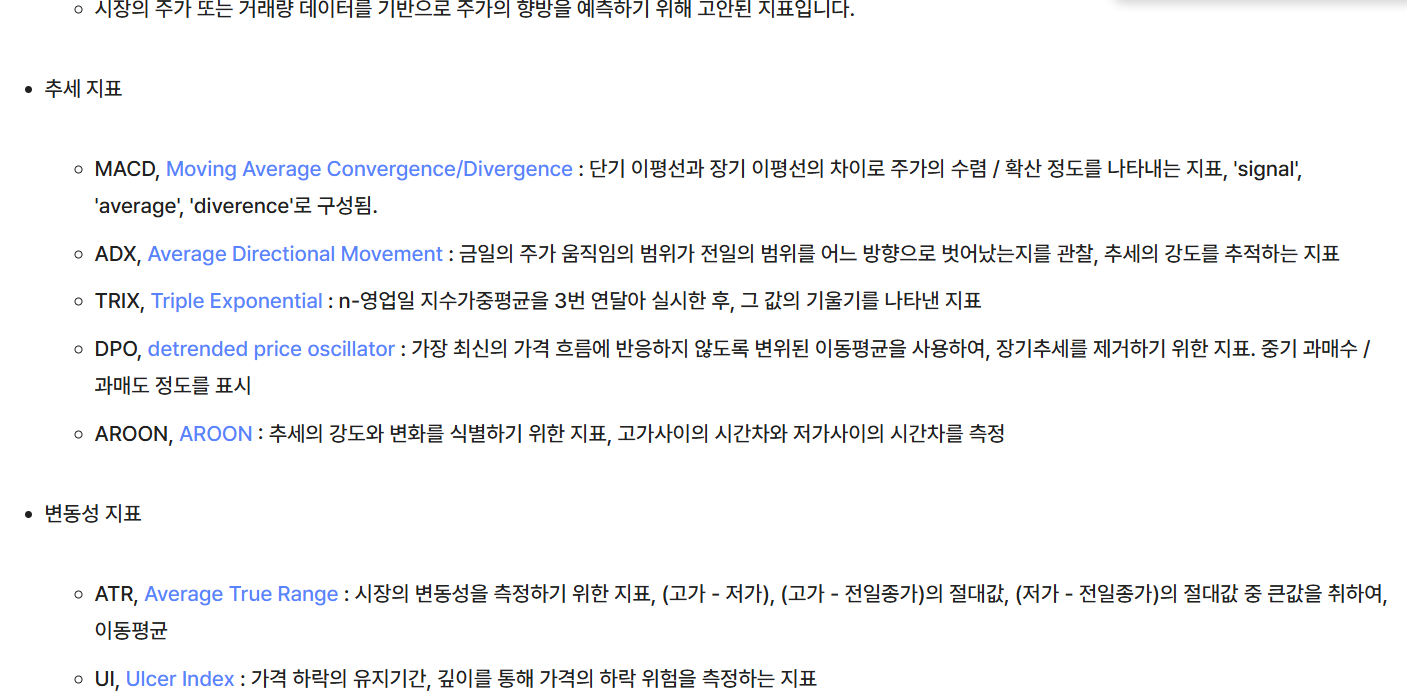
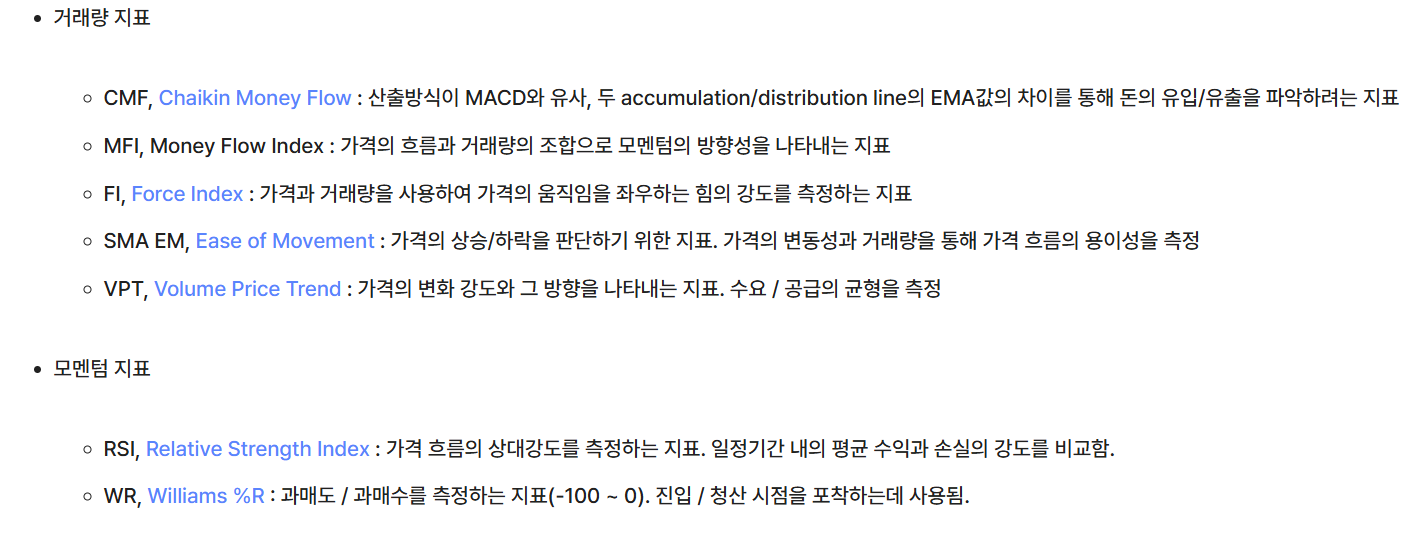

### 추세지표 ? chaikin 은 추세라 보기 어렵다고 하네

In [8]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()

In [9]:
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols=[open, high, low, close, volume]

In [10]:
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()

In [11]:
df_

,open,high,low,close,volume,volume_cmf
time,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN
...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093


In [12]:
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()

In [13]:
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

/opt/conda/lib/python3.9/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/conda/lib/python3.9/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


② 수익률 / 변동성 지표
- 여러 지표들이 추가된 데이터셋에서 활용하고자 하는 시점에 수익률과 변동성 적용

수익률 / 변동성까지 적용된 데이터셋을 표준화(standardization)하고 fit_transform하여 RandomForest에 적용합니다. 아래 Feature Selection을 하기 위한 선행과정입니다.


* Python의 TA 패키지를 이용하여 각 지표를 산출할 수 있습니다.(ta 공식 문서 참고 - https://technical-analysis-library-in-python.readthedocs.io/en/latest/index.html)

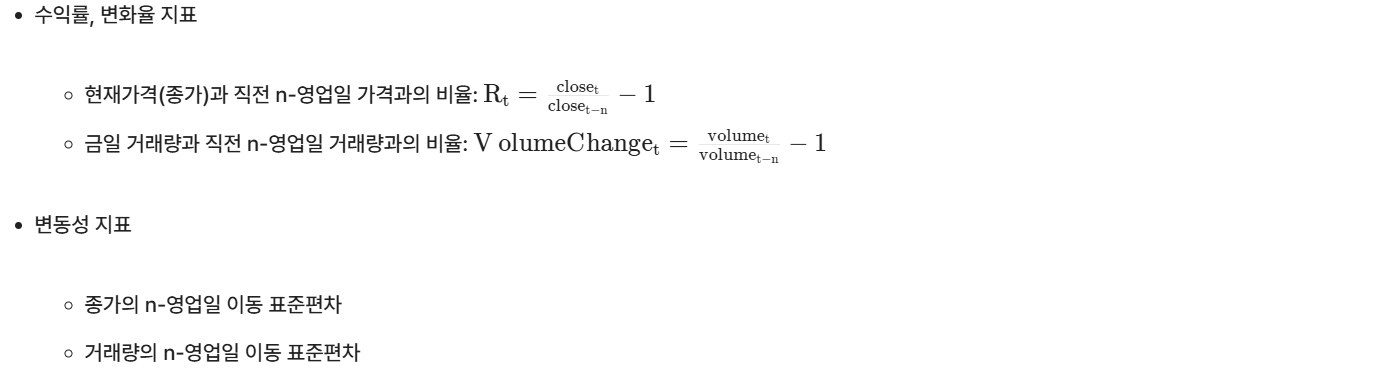

In [17]:
windows_mom = [5, 10, 20]
windows_std = [30]


# pct_change :  (다음행 - 현재행)÷현재행 
# rolling - 이동평균, 이동합계, 이동표준편차 가능
for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [18]:
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [19]:
df_tmp_data = df_.join(df_label_data).dropna()

In [24]:
pd.options.display.max_columns = None

In [26]:
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

In [27]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [28]:
X_sc

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,-0.207030,2.302909,0.353806,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,-0.244806,0.426908,0.353806,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,-0.326263,1.493654,0.266876,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,-0.271341,0.242987,1.310037,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,-0.271648,1.138072,1.310037,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,-1.315704,-0.287078,0.964449,-0.694987,-0.028358,-1.154914,0.009347,1.119360,-0.213129,-1.070983,-0.927841,-0.088072,-0.863215,0.091216,1.457839,-0.290098,0.683646,-0.263339,0.809831,-0.049429,-0.113254,-0.671848,-1.323649
2018-01-01 16:36:00,-1.052102,-0.373901,0.756529,-0.671205,-0.202126,-0.951719,-0.032148,0.829596,-0.171873,-1.002590,-0.947228,-1.007680,-0.863215,-0.789172,-0.596892,-0.103629,-0.053926,-0.156305,0.255031,-0.320415,-0.504179,-0.686893,-1.747571
2018-01-01 16:37:00,-1.033515,-0.368059,1.141100,-1.437940,-0.221777,-1.025471,-0.056373,0.483158,-0.108723,-0.953990,-0.977408,-0.921850,-0.863215,-1.082014,-1.418785,-0.207305,-0.643426,-0.331387,0.033018,-0.365897,-0.660549,-0.702092,-1.748596


In [29]:
## 랜덤포레스트 분류
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## 3. Feature Selection methods
특성선택(Feature Selection)을 위한 기법

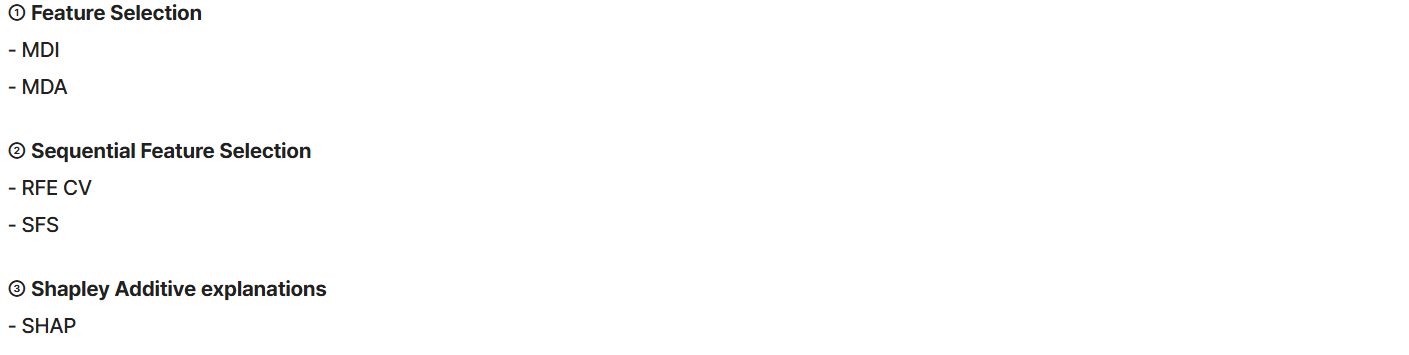


### ① Feature Selection
MDI ( Mean Decrease Impurity )
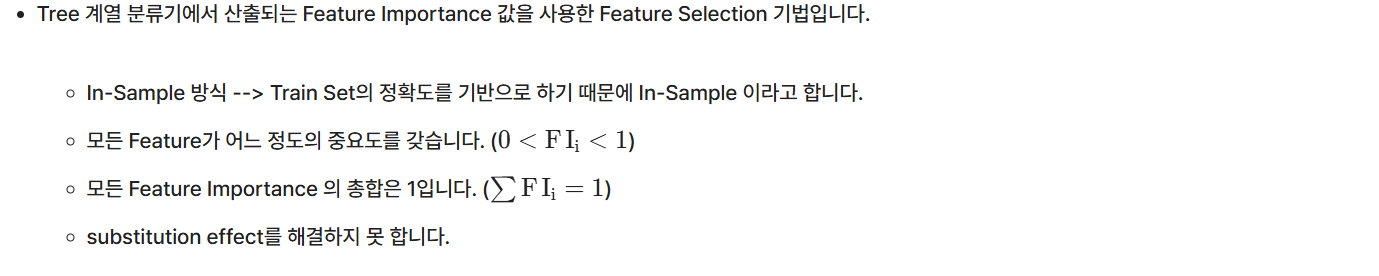

In [30]:
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)

In [31]:
feat_imp

,mean,std
volume_cmf,0.048869,0.002502
volume_fi,0.044398,0.002489
volume_mfi,0.045190,0.002266
volume_sma_em,0.035460,0.001671
volume_vpt,0.026453,0.001640
volatility_atr,0.081342,0.003477
volatility_ui,0.047577,0.002646
trend_macd_diff,0.077333,0.003763
trend_adx,0.055446,0.002438
trend_trix,0.068122,0.003093


MDA ( Mean Decrease Accuracy )
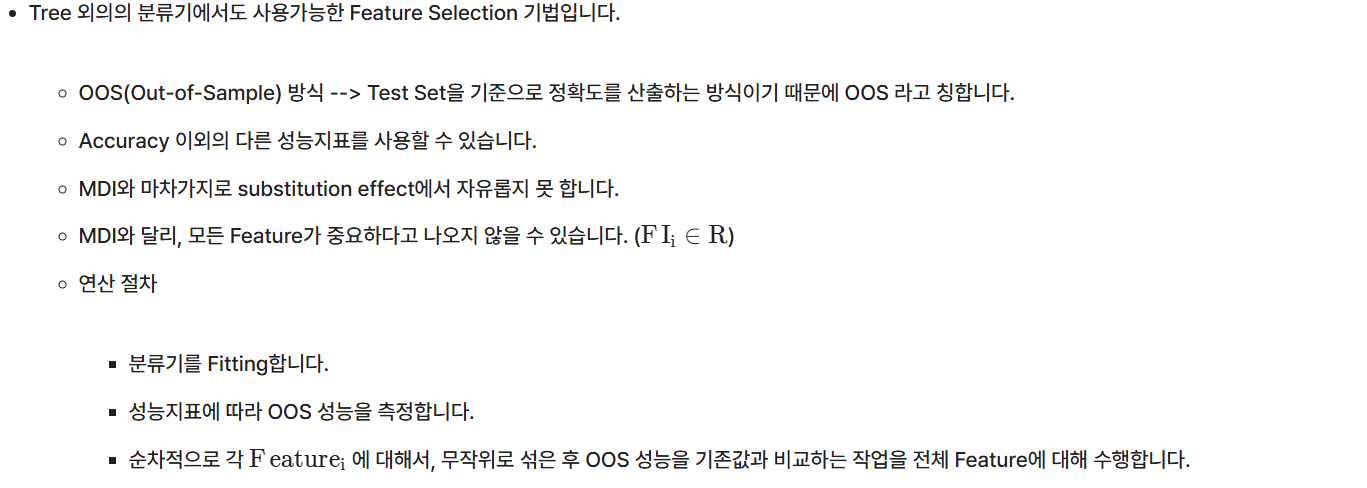

In [32]:
svc_rbf = SVC(kernel = 'rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

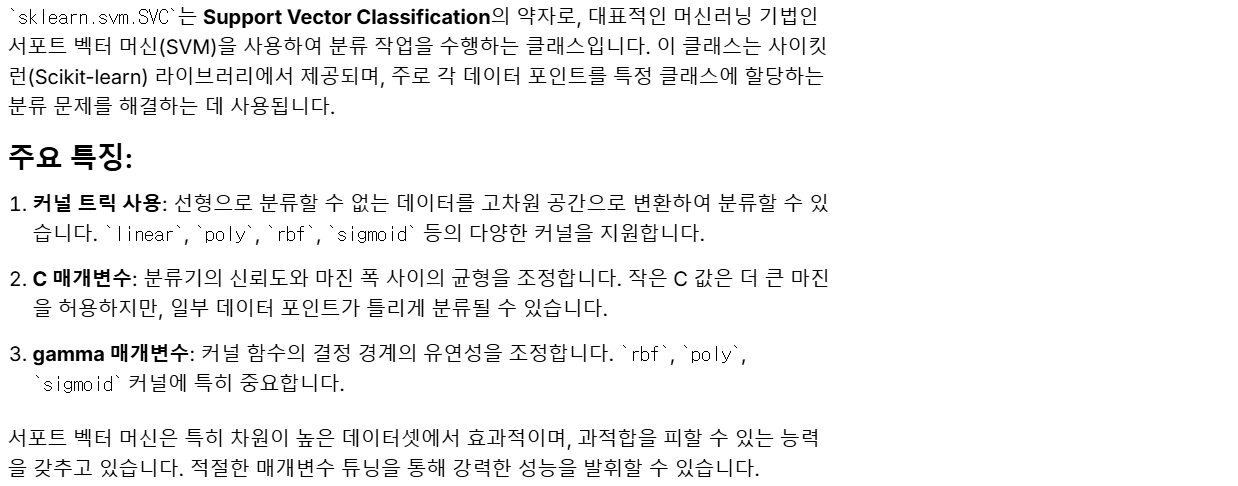

In [33]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

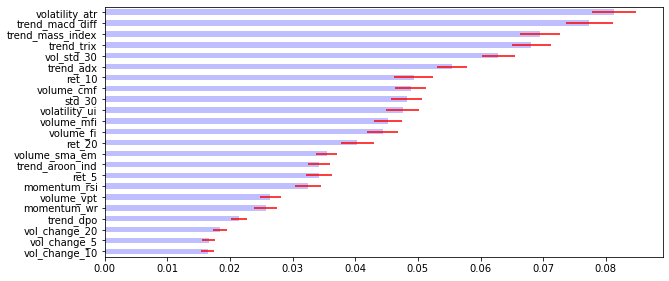

In [34]:
plot_feature_importance(feat_imp)

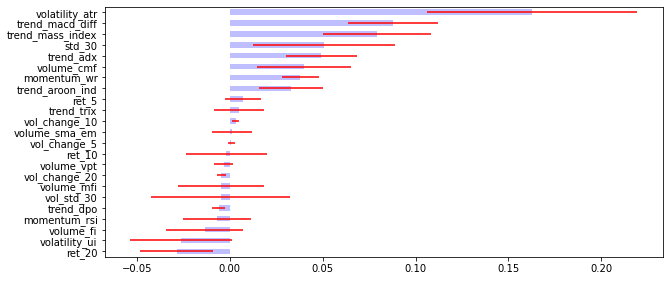

In [35]:
plot_feature_importance(feat_imp_mda)

② Sequential Feature Selection
RFE ( Recursive Feature Elimination : 재귀적 기능 제거 ) CV

* Data Set을 K개로 분할하여 학습과 검증을 동시에 진행하며, 검증시 Feature의 기여도에 따라 삭제 여부를 결정하는 방식을 말합니다.
* Validation 성능이 가장 좋은 Feature를 최종 Feature로 결정합니다.

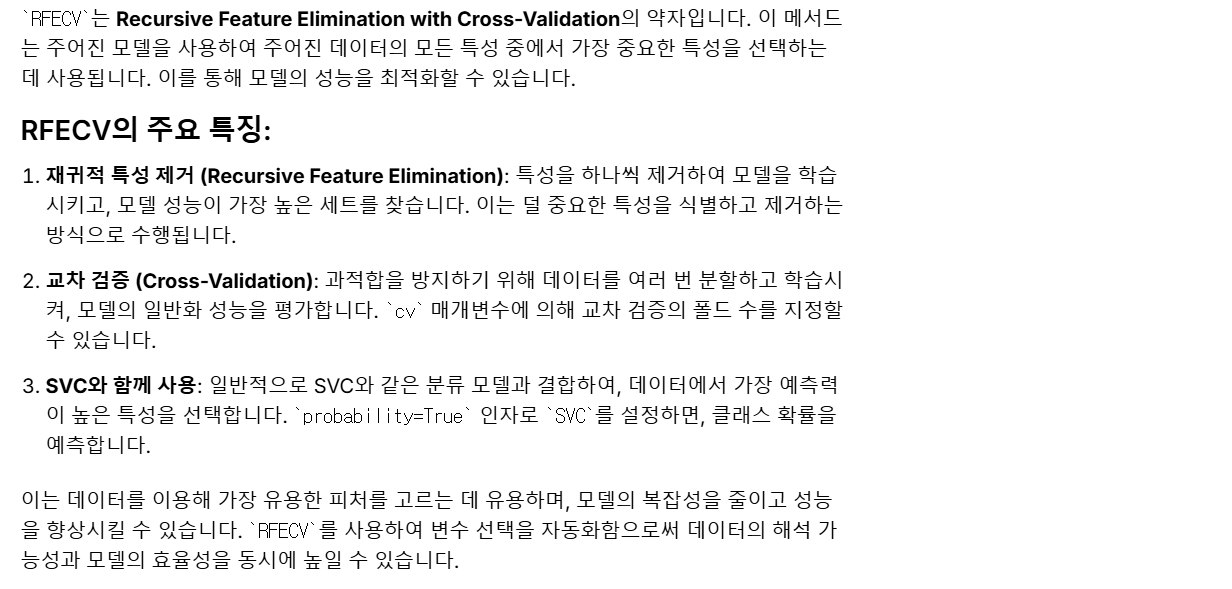

In [37]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)  ## 재귀적 특성 제거
rfe_fitted = rfe_cv.fit(X_sc, y)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


In [41]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})

In [42]:
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [43]:
rfe_df[rfe_df['Optimal_Features'] == True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


SFS ( Sequential Feature Selection )
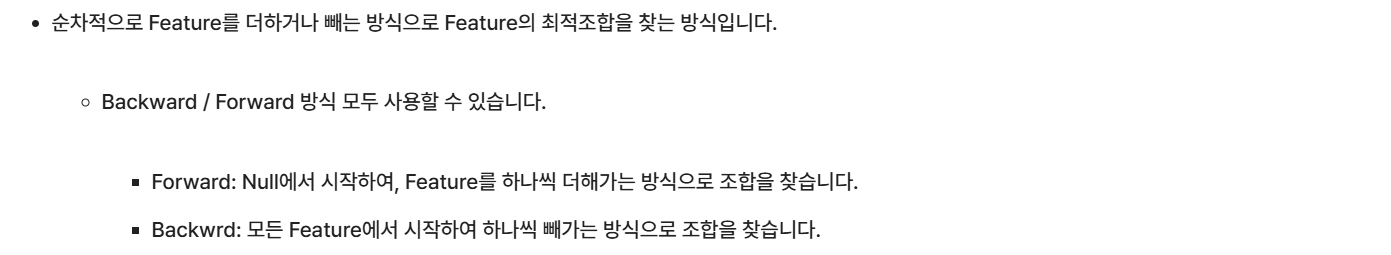

In [44]:
n = 2

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [45]:
sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

### ③ SHAP, Shapley Additive explanations
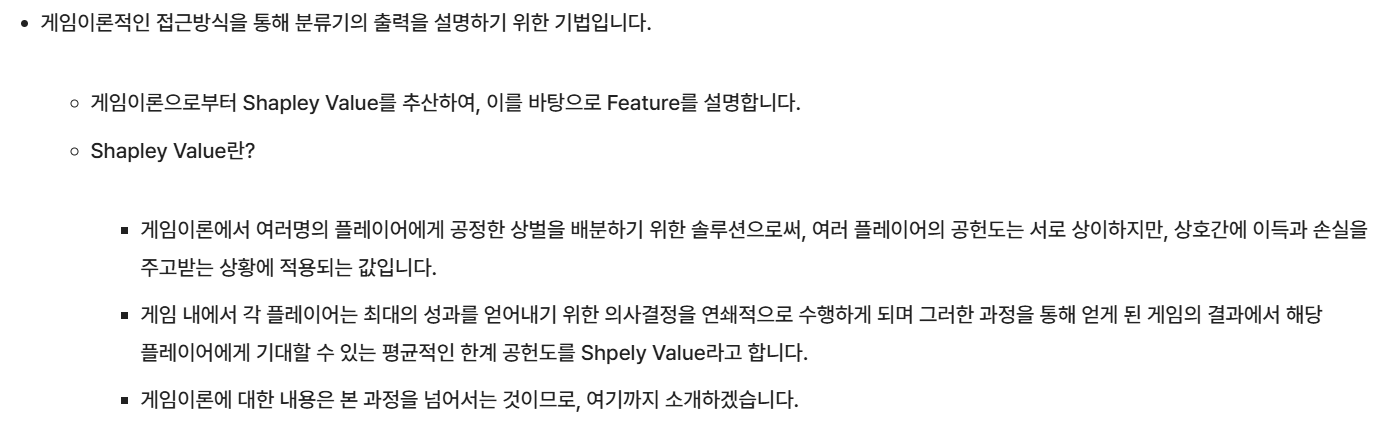
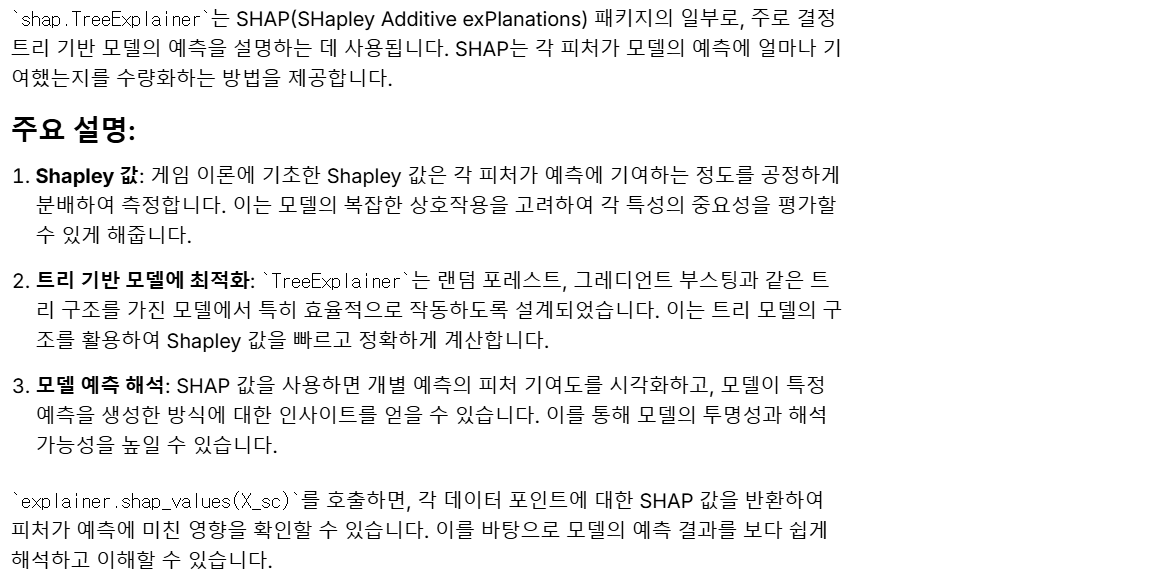

In [46]:
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

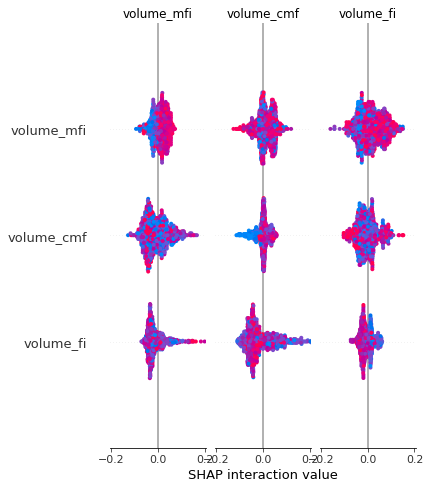

In [47]:
shap.summary_plot(shap_value, X_sc)

In [48]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)